In [476]:
import requests
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
#from fa2 import ForceAtlas2
import seaborn as sns
import numpy as np
from pprint import pprint
import matplotlib.cm as cm
sns.set()

# All characters 

In [4]:
baseurl = "https://southpark.fandom.com/api.php?"
action = "action=query"
title = "titles=Portal:Characters"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
someOtherThing = "rvslots=*"
query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title, dataformat,someOtherThing)

# Making a get request
response = requests.get(query)
# charactrters_page = response.json()['query']['pages']['44865']['revisions'][0]['slots']['main']['*']

In [5]:
charactrters_page_all = response.json()['query']['pages']['3590']['revisions'][0]['slots']['main']['*']

In [6]:
characters_all  = re.findall('\[\[[a-zA-Z0-9\'\\ -.]*\]\]', charactrters_page_all)
characters_all = list(set([w.replace('[[', '').replace(']]', '') for w in characters_all]))

In [7]:
len(characters_all)

1832

# Categories

In [11]:
baseurl = "https://southpark.fandom.com/api.php?"
action = "action=query"
title = "titles=Portal:Characters/Categorized_Characters"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
someOtherThing = "rvslots=*"
query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title, dataformat,someOtherThing)

# Making a get request
response = requests.get(query)
charactrters_page_cat = response.json()['query']['pages']['44865']['revisions'][0]['slots']['main']['*']

In [12]:
charactrters_page_cat = charactrters_page_cat.replace('\u200e', '')
Categorized_Characters = re.findall('==[a-zA-Z0-9\'\\ -.]*==', charactrters_page_cat)

In [14]:
len(Categorized_Characters)

30

In [15]:
text_characters = {}
for i in range(len(Categorized_Characters)):
    if i < len(Categorized_Characters)-1:
        text_characters[Categorized_Characters[i]] = charactrters_page_cat[charactrters_page_cat.index(Categorized_Characters[i])+len(Categorized_Characters[i]):charactrters_page_cat.index(Categorized_Characters[i+1])]
    else:
        text_characters[Categorized_Characters[i]] = charactrters_page_cat[charactrters_page_cat.index(Categorized_Characters[i])+len(Categorized_Characters[i]):]

In [16]:
characters_category = {}
for key in text_characters:
    key_clean = key.replace('==', '')
    characters_category[key_clean] = re.findall('\[\[[a-zA-Z \']*\]\]',text_characters[key])
    characters_category[key_clean] = [w.replace('[[', '').replace(']]', '') for w in characters_category[key_clean]]

In [301]:
categories = {'School Characters': ['Kindergartners',
  '1st-3rd Graders',
  '4th Graders',
  '5th-9th Graders',
  'School Faculty'],
 'Creatures': ['Aliens', 'Animals', 'Monsters'],
 'Other': ['Alter Egos ',
  'Crossover characters',
  'Internet Trolls',
  "Paris Hilton's Pets ",
  'Raisins Employees',
  'Animated South Park Fans ',
  'Unnamed Characters', 
  'Groups'],
 'Celebrities': ['Business Celebrities',
  'Criminal Celebrities',
  'Fictional Celebrities',
  'Historical Celebrities',
  'Internet Celebrities',
  'Music Celebrities',
  'Political Celebrities',
  'Religious Figures',
  'Sports Celebrities',
  'Television Celebrities']}

In [18]:
categorised_characters = {}
count = 0
for main_category in categories:
    categorised_characters[main_category] = {}
    for sub_category in categories[main_category]:
        categorised_characters[main_category][sub_category] = characters_category[sub_category]
        count += len(categorised_characters[main_category][sub_category])

In [19]:
count

847

# Data Frame

In [20]:
characters = {}
for character in characters_all:
    characters[character] = [None, None]
    for main_key in categorised_characters.keys():
        for sub_key in categorised_characters[main_key]:
            if character in categorised_characters[main_key][sub_key]:
                characters[character][0], characters[character][1]  = main_key, sub_key

In [21]:
'George Bush'  'George W. Bush'

'George BushGeorge W. Bush'

In [22]:
df_characters = pd.DataFrame.from_dict(characters, orient='index', columns=['Main Category', 'Sub Category'])

In [23]:
df_characters = df_characters.reset_index()

In [24]:
df_characters.columns = ['Name', 'Main Category', 'Sub Category']

In [25]:
df_characters[df_characters['Name'].str.startswith('George')]

,Name,Main Category,Sub Category
12,George W. Bush,None,None
17,George Clooney,None,None
162,George Lucas,None,None
267,George Zimmerman,Celebrities,Political Celebrities
775,George Burns,None,None
1202,George Washington,None,None
1564,George R. R. Martin,None,None


In [31]:
def downloadCharacterPage(character):
    character = character.replace("&", "%26")
    jerome = False
    if character == "Darth Chef":
        character = "Jerome \"Chef\" McElroy#Darth Chef"
        jerome = True
    baseurl = "https://southpark.fandom.com/api.php?"
    action = "action=query"
    title = "titles=" + character.replace(" ", "_")
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    someOtherThing = "rvslots=*"
    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title, dataformat,someOtherThing)
    response = requests.get(query)
    if jerome:
         return response.text
    if re.search('\#REDIRECT', response.text) == None:
        return response.json()
    try:
        newTitle = re.findall(r'[[*[A-Za-z0-9 ., _()]*\]]', response.text)
        newTitle = newTitle[0].split('[[')
        print("old char :", character, " | new char: ", newTitle[1][:-2])
        return downloadCharacterPage(newTitle[1][:-2])
    except:
        print("Fucks up: ",character)
    

def downloadCharacterFromList(character_list):
    for char in character_list:
        page = downloadCharacterPage(char)
        if not isinstance(page, str):
            try:
                key = list(page['query']['pages'].keys())
                page = page['query']['pages'][key[0]]['revisions'][0]['slots']['main']['*']
            except:
                print(char)
                break
        with open('southpark_pages/' + char.replace("\"", "") + '.txt', 'w', encoding='utf-8') as f:
            f.write(page)

In [62]:
#downloadCharacterFromList(df_characters.Name.values)

## GCC 
I will go over every single character and read out the text from its txt file

In [32]:
df_characters.head()

,Name,Main Category,Sub Category
0,Benjamin Franklin,Celebrities,Historical Celebrities
1,Sia,None,None
2,Annie Knitts,School Characters,4th Graders
3,William Janus,None,None
4,Peter Panda,Other,Alter Egos


In [33]:
def get_characters(data):
    potential_links = re.findall("\[\[*[A-Za-z _()\|\']*\]\]",data)
    potential_links = [x.split('[') for x in potential_links]
    potential_links = [x[2].split(']') for x in potential_links]
    potential_links = [x[0] for x in potential_links]
    potential_links = [x.split('|')[0] for x in potential_links]
    # removing doubles 
    characters = []
    potential_links = list(set(potential_links))
    for pot in potential_links:
        if pot in df_characters.Name.values:
            characters.append(pot)
    return characters
def make_connection(characterlist, name, G):
    for i in characterlist:
        G.add_edge(name, i)
    return G

In [44]:
G = nx.DiGraph()
df_num_characters = pd.DataFrame(columns=['Name', 'Data_characters'])
for index, Row in df_characters.T.iteritems():
    name = Row.Name
    G.add_node(name)
    with open('southpark_pages/' + name.replace("\"", "") + ".txt", 'r', encoding='utf-8' ) as file:
        data = file.read()
    # Finding characters that links to person and create the link
    G = make_connection(get_characters(data),name, G)

Getting the gcc

In [47]:
G_large = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()

In [48]:
gcc = G_large.to_undirected()

### Plotting gcc

In [49]:
# set node size depending on degree
node_sizes = [2*v for v in dict(gcc.degree).values()]

In [29]:
# Setup FA2 w. parameters
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,    # Dissuade hubs
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=True,
    gravity=1.0,

    # Log
    verbose=False
)

# compute node positions with the fa algorithm
node_pos = forceatlas2.forceatlas2_networkx_layout(gcc, pos=None, iterations=2000)

C:\Users\mailt\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


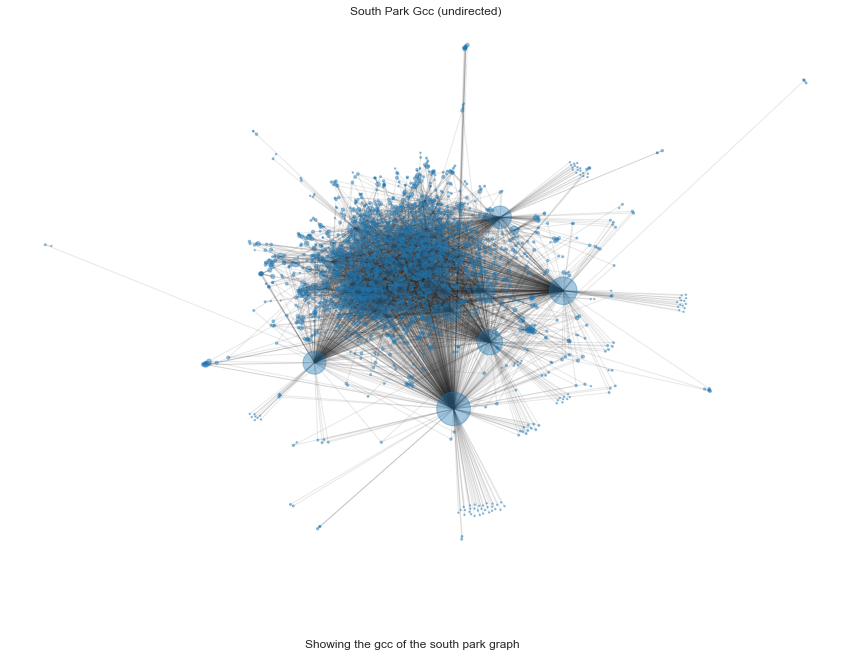

In [30]:
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(gcc, node_pos, node_size=node_sizes, alpha=0.4)
nx.draw_networkx_edges(gcc, node_pos, alpha=0.1)
plt.title('South Park Gcc (undirected)')
plt.axis('off')
fig_text = """Showing the gcc of the south park graph"""
plt.figtext(
    0.5, 0.01, wrap=True, horizontalalignment='center', fontsize=12, s=fig_text
)
plt.savefig("Graph.png", format="PNG")
plt.show()

## Newtork analysis
First i find the characters with most indegrees and out degrees, this is done on the directed graph gcc

In [50]:
degree_list_in = sorted(G_large.in_degree, key=lambda x: x[1], reverse=True)
degree_list_out = sorted(G_large.out_degree, key=lambda x: x[1], reverse=True)

In [51]:
print("Top 5 in degree characters")
for node, degree in degree_list_in[0:5]:
    print(f'{node}: {degree}')
print("\nTop 5 out degree characters")
for node, degree in degree_list_out[0:5]:
    print(f'{node}: {degree}')

Top 5 in degree characters
Eric Cartman: 555
Stan Marsh: 373
Kyle Broflovski: 321
Butters Stotch: 254
Randy Marsh: 241

Top 5 out degree characters
Eric Cartman: 95
Heidi Turner: 80
The 4th Grade: 58
Stan Marsh: 51
Randy Marsh: 50


In [34]:
degrees_in = np.array([d for _, d in G_large.in_degree])
degrees_out = np.array([d for _, d in G_large.out_degree])
in_deg, in_deg_count = np.unique(degree_list_in, return_counts=True)
out_deg, out_deg_count = np.unique(degree_list_out, return_counts=True)

In [36]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

# set titles
ax[0].set_title('In-degree distribution')
ax[1].set_title('Out-degree distribution')

# set axis labels
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('in-degree')
ax[1].set_xlabel('out-degree')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# plot distributions
ax[0].plot(in_deg, in_deg_count, '.')
ax[1].plot(out_deg, out_deg_count, '.')

fig_text = """Plot of in- AND out-degree distribution"""
plt.figtext(
    0.5, -0.15, wrap=True, horizontalalignment='center', fontsize=12, s=fig_text
)
plt.savefig("degree_distribution.png", format="PNG")
plt.show()

C:\Users\mailt\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()
C:\Users\mailt\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 8)) 
plt.loglog(in_deg, in_count, 'go-', label='in-degree') 
plt.loglog(out_deg, out_count, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show

## Wordclouds 

First i need to clean the pages. We are starting with the 4 main characters (Eric Cartman, Stan Marsh, Kyle Broflovski, Kenny McCormick)

In [37]:
from nltk import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from math import log
import nltk
from wordcloud import WordCloud

C:\Users\mailt\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\mailt\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

In [38]:
main_characters = ["Eric Cartman", "Stan Marsh", "Kyle Broflovski", "Kenny McCormick"]

In [39]:
def clean_data(character):
    with open('soutpark_pages/' + character + ".txt", 'r', encoding='utf-8' ) as file:
        data = file.read()
    test = re.sub('{{[a-zA-Z0-9\'\\ / -.|=:<>?]*}}', '', data)
    test = re.sub("==[a-zA-Z0-9\'\\ -.:<>?]*==",'',test)
    test = re.sub("===[a-zA-Z0-9\'\\ -.:<>?]*===",'',test)
    test = re.sub("\[\[[a-zA-Z0-9\'\\ -.:()|<>?]*\]\]",'',test)
    test = re.sub("\\n",' ',test)
    test = re.sub(r'http\S+', '', test)
    test = re.sub("<[^>]*>",'',test)
    test = re.sub("[a-zA-Z 0-9-.]*.png",'',test)
    test = re.sub("[a-zA-Z 0-9-.]*.jpg",'',test)
    test = re.sub('[^A-Za-z ]+', '', test)

    tk = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    text_tokenized = tk.tokenize(test)
    blacklist = stopwords.words()
    text_lemmatized = [lemmatizer.lemmatize(w.lower()) for w in text_tokenized if w.lower() not in blacklist]
    return text_lemmatized

In [40]:
cleaned_data = {}
for char in main_characters:
    cleaned_data[char] = clean_data(char)

I am going to use tf-idf to create the wordclouds.

In [41]:
south_park_text = cleaned_data.values()
south_park_text = [item for sublist in list(south_park_text) for item in sublist]

In [42]:
# Calculating idf
num_doc = len(main_characters)
idf_dic =  {}
for i in set(south_park_text):
    t_in_doc = 0
    for j in main_characters:
        if i in cleaned_data[j]:
            t_in_doc += 1
    idf_dic[i] = log(num_doc/t_in_doc)

# calculating tf-idf
for i in main_characters:
    words = nltk.Text(cleaned_data[i])
    fdist1 = nltk.FreqDist(words)
    length = len(cleaned_data[i])
    cleaned_data[i+'_tf_idf'] = [(word+ " ") * (round(idf_dic[word])*freq) for word, freq in fdist1.items()]

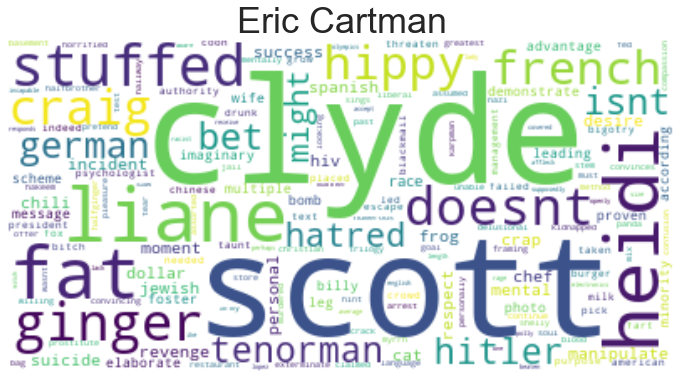

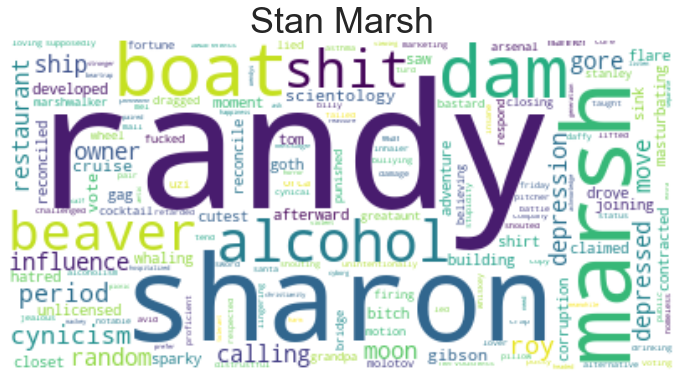

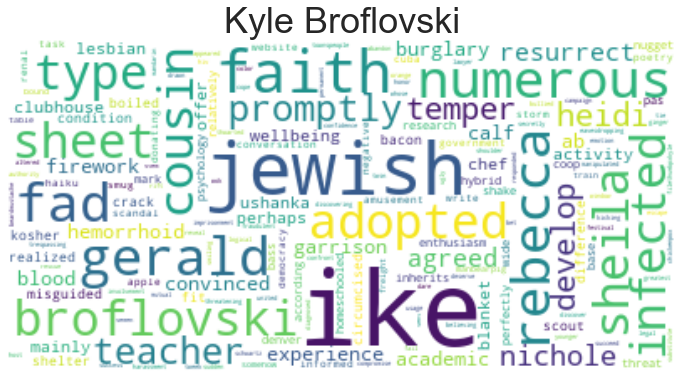

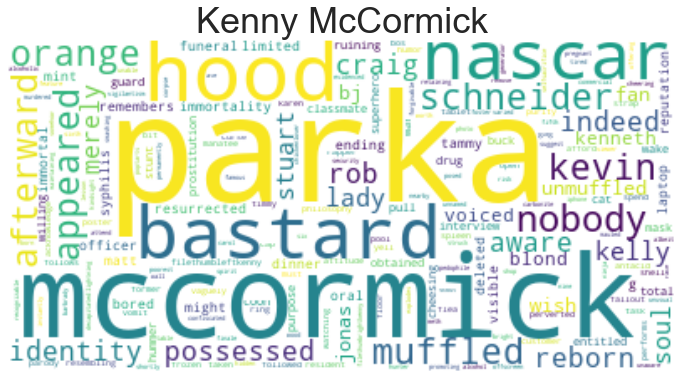

In [43]:
for i in main_characters:
    text = " ".join(cleaned_data[i+'_tf_idf'])
    wordcloud = WordCloud(collocations=False,background_color="white").generate(text)
    # Display the generated image:
    # the matplotlib way:
    plt.figure(figsize=(12,8))
    plt.title(i, size=36)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(i+".png", format="PNG")
    plt.show()

## Character Categories 

In [427]:
df_categories=df_characters.copy()
del df_categories['Main Category']
del df_categories['Sub Category']
categories_list=[]
for index, Row in df_categories.T.iteritems():
    name = Row.Name
    with open('southpark_pages/' + name.replace("\"", "") + ".txt", 'r', encoding='utf-8' ) as file:
        data = file.read()
        categories_list.append(re.findall(r'(?<=\[\[Category:)(.*?)(?=\])',data))
df_categories['Categories'] = categories_list

In [428]:
def compare(categoriesx):
    categories = ['School Characters','Kindergartners',
  '1st-3rd Graders',
  '4th Graders',
  '5th-9th Graders',
  'School Faculty',
 'Creatures','Aliens', 'Animals', 'Monsters',
 'Other', 'Alter Egos ',
  'Crossover characters',
  'Internet Trolls',
  "Paris Hilton's Pets ",
  'Raisins Employees',
  'Animated South Park Fans ',
  'Unnamed Characters', 
  'Groups',
 'Celebrities','Business Celebrities',
  'Criminal Celebrities',
  'Fictional Celebrities',
  'Historical Celebrities',
  'Internet Celebrities',
  'Music Celebrities',
  'Political Celebrities',
  'Religious Figures',
  'Sports Celebrities',
  'Television Celebrities']
    categories=[x.lower() for x in categories]
    categoriesx=[x.lower() for x in categoriesx]
    return list(set(categories).intersection(categoriesx))

df_categories['commonValues'] = df_categories.Categories.apply(lambda x: compare(x))

In [429]:
df_categories['commonValues'] = df_categories['commonValues'].apply(lambda y: ["uncategorized"] if len(y)==0 else y)

In [430]:
df_categories=df_categories.rename(columns={"commonValues": "mainCategories"})

In [433]:
def to_1D(df):
    return pd.Series([x for _list in df for x in _list])

plotdf=to_1D(df_categories['mainCategories']).value_counts()

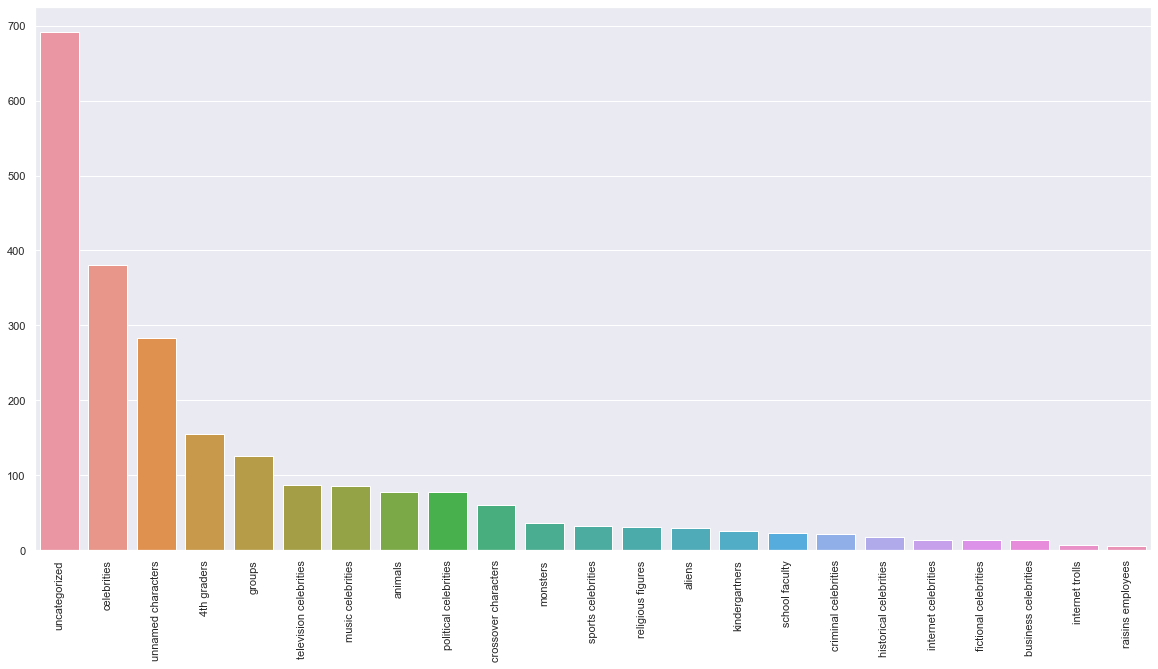

In [434]:
fig, ax = plt.subplots(figsize=(20,10))
all_plot = sns.barplot(x=plotdf.keys(), y=plotdf.values, ax=ax)
plt.xticks(rotation=90);

In [462]:
from community import community_louvain
from collections import Counter
partition=community_louvain.best_partition(gcc)
# The communities and the number of nodes in each
print(Counter(list(partition.values())))
# the number of communities
print(len(Counter(list(partition.values()))))

Counter({7: 216, 1: 173, 15: 151, 13: 151, 16: 138, 14: 132, 10: 111, 9: 108, 11: 103, 8: 101, 4: 96, 0: 89, 6: 84, 2: 31, 5: 9, 3: 8, 12: 7})
17


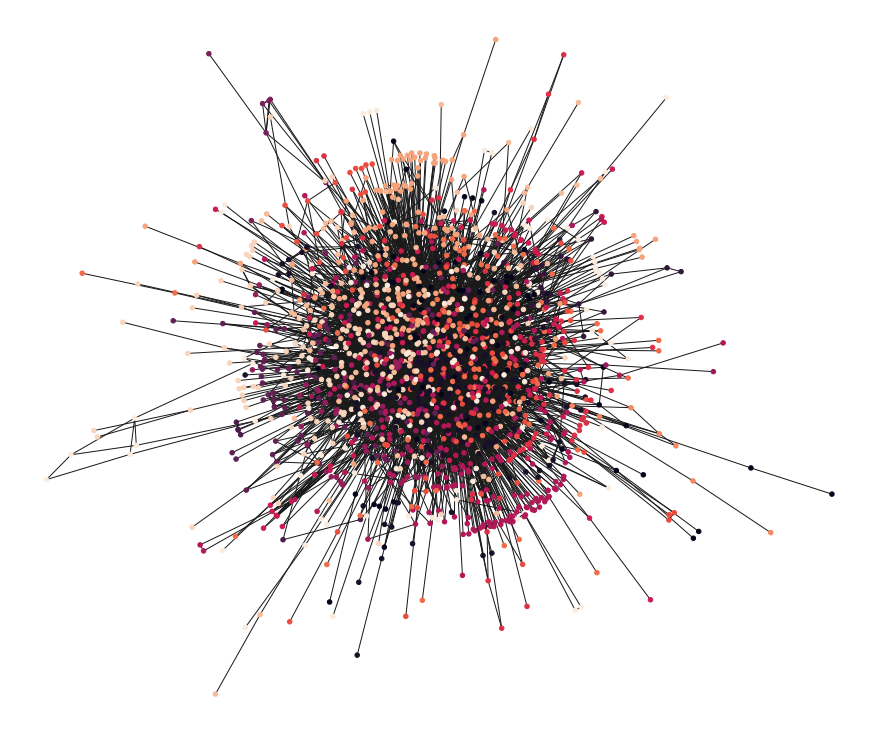

The modularity of the network is: 0.058289944315751435


In [484]:
plt.figure(figsize=(12,10))
nx.draw(gcc,pos,node_size=20,node_color=list(partition.values()))
plt.show()
modularity=nx.algorithms.community.modularity(gcc,communities)
print("The modularity of the network is: "+ str(modularity))

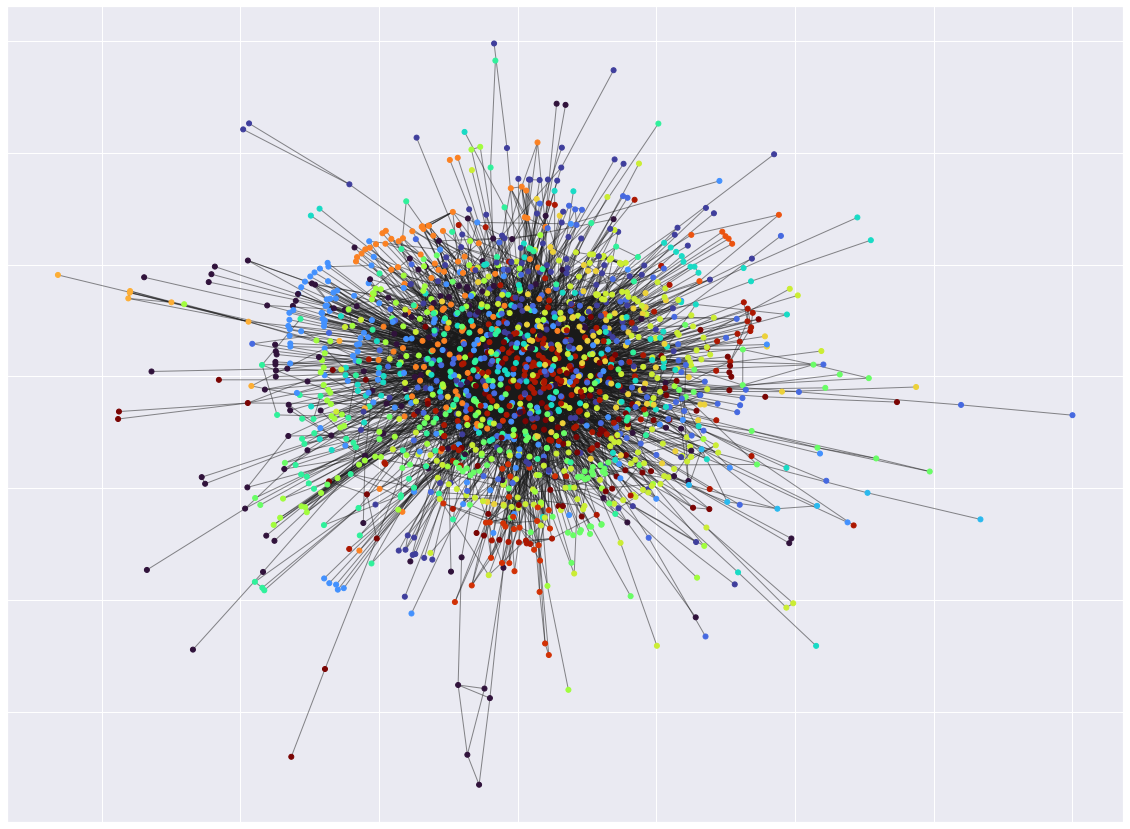

In [485]:
pos = nx.spring_layout(gcc)
plt.figure(figsize=(20,15))
# Node communities
cmap = cm.get_cmap('turbo_r', max(partition.values()) + 1)
nx.draw_networkx_nodes(gcc, pos, partition.keys(), node_size=25,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(gcc, pos, alpha=0.5)
plt.show()

In [467]:
flip = {} 
temp=[]
communities=[]
for key, value in partition.items(): 
    if value not in flip: 
        flip[value] = [key] 
    else: 
        flip[value].append(key) 
for i in range(len(list(flip.values()))):
               communities.append((list(flip.values())[i]))

temp=[[x for x in i]for i in communities]
communities=temp

In [468]:
communities.sort(key=len, reverse=True)

In [470]:
#naming each community after their 3 most connected characters. 
num_edges = {}
for i in range(len(communities)):
    edge_list = []
    for node in temp[i]:
        edge_list.append((node,len(gcc.edges(node))))
    num_edges[i] = sorted(edge_list, key = lambda tup : tup[1], reverse = True)

In [471]:
communities_dict = {}
for i in range(len(communities)):
    name = ' '.join([x for x,y in num_edges[i][:3]]).replace(" ","_")
    communities_dict[name] = communities[i]

In [577]:
#df_categories.loc[df_categories['Name'] == 'Eric Cartman']
communities_list=list(communities_dict.keys())
communities_members=list(communities_dict.values())
for i in communities_members[0]:
    if i in df_categories.values:
        print((df_categories.values[0][2][1]))

celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
celebrities
cele